In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import spotipy
import seaborn as sns
import datetime

from spotipy.oauth2 import SpotifyOAuth
from matplotlib import cm
from matplotlib.colors import Normalize
from datetime import datetime, timedelta
from wordcloud import WordCloud
from langdetect import detect
from collections import Counter


**ts:** This field is a timestamp indicating when the track stopped playing in UTC (Coordinated Universal Time). The order is year, month and day followed by a timestamp in military time

**username:** This field is your Spotify username.

**platform:** This field is the platform used when streaming the track (e.g. Android OS, Google Chromecast).

**ms_played:** This field is the number of milliseconds the stream was played.

**conn_country:** This field is the country code of the country where the stream was played (e.g. SE - Sweden).

**ip_addr_decrypted:** This field contains the IP address logged when streaming the track.

**user_agent_decrypted:** This field contains the user agent used when streaming the track (e.g. a browser, like Mozilla Firefox, or Safari)

**master_metadata_track_name:** This field is the name of the track.

**master_metadata_album_artist_name:** This field is the name of the artist, band or podcast.

**master_metadata_album_album_name:** This field is the name of the album of the track.

**spotify_track_uri:** A Spotify URI, uniquely identifying the track in the form of “spotify: track: string>”
A Spotify URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an artist, album, or track.
    
**episode_name:** This field contains the name of the episode of the podcast.

**episode_show_name:** This field contains the name of the show of the podcast.

**spotify_episode_uri:** A Spotify Episode URI, uniquely identifying the podcast episode in the form of “spotify episode:string>”
A Spotify Episode URI is a resource identifier that you can enter, for example, in the Spotify Desktop client’s search box to locate an episode of a podcast.

**reason_start:** This field is a value telling why the track started (e.g. “trackdone”)

**reason_end:** This field is a value telling why the track ended (e.g. “endplay”).

**shuffle:** This field has the value True or False depending on if shuffle mode was used when playing the track.

**skipped:** This field indicates if the user skipped to the next song

**offline:** This field indicates whether the track was played in offline mode (“True”) or not (“False”).

**offline_timestamp:** This field is a timestamp of when offline mode was used, if used.

**incognito_mode:** This field indicates whether the track was played in incognito mode (“True”) or not (“False”).


In [4]:

# Directory containing your Excel files
directory = '/Users/Sarah/Downloads/CS 210/Project/Spotify/Spotify Excel'

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each Excel file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx') or filename.endswith('.xls'):
        file_path = os.path.join(directory, filename)

        # Read the Excel file into a DataFrame and append to the list
        df = pd.read_excel(file_path)
        dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Convert 'ts' to datetime and adjust for timezone
df['ts'] = pd.to_datetime(df['ts'], format='%Y-%m-%d %H:%M:%S') - timedelta(hours=6)

# Display the combined DataFrame
print(df)
print("Header:", df.columns.tolist())

                             ts    username platform  ms_played conn_country  \
0     2022-11-03 07:22:07+00:00  sarahellya  windows   166492.0           SG   
1     2022-11-03 07:24:31+00:00  sarahellya  windows   143773.0           SG   
2     2022-11-03 07:24:35+00:00  sarahellya  windows     2273.0           SG   
3     2022-11-03 07:24:37+00:00  sarahellya  windows     1980.0           SG   
4     2022-11-03 07:29:19+00:00  sarahellya  windows   234413.0           SG   
...                         ...         ...      ...        ...          ...   
42007 2023-12-07 14:54:59+00:00  sarahellya      ios     1300.0           TR   
42008 2023-12-07 14:55:00+00:00  sarahellya      ios     1648.0           TR   
42009 2023-12-07 14:59:00+00:00  sarahellya      ios   240294.0           TR   
42010 2023-12-07 15:07:27+00:00  sarahellya      ios    18665.0           TR   
42011 2023-12-07 15:09:06+00:00  sarahellya      ios    98127.0           TR   

      ip_addr_decrypted user_agent_decr

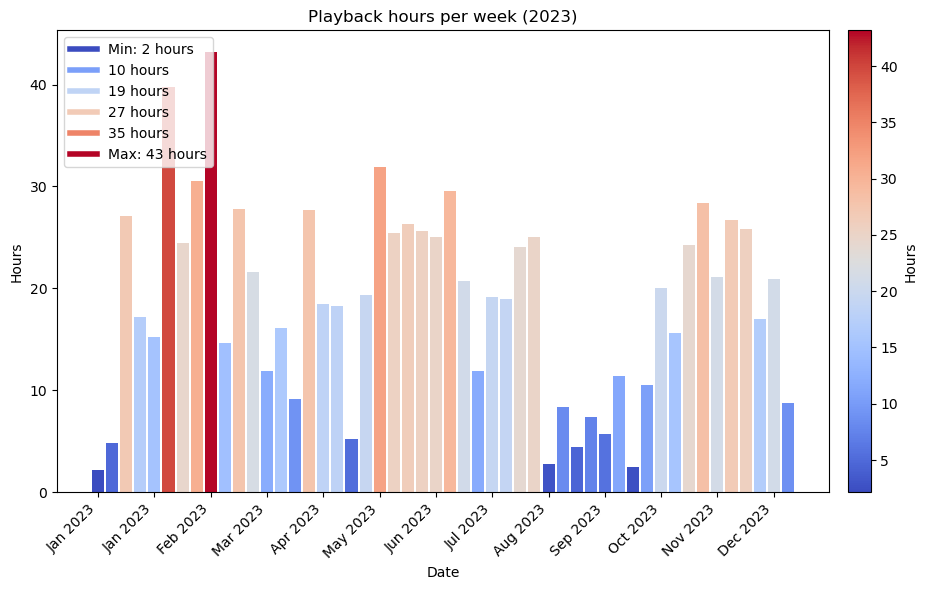

In [5]:
# Filter data for the period of 2022 and 2023
start_date = '2023-01-01'
end_date = '2023-12-31'
df = df[(df['ts'] >= start_date) & (df['ts'] <= end_date)]

# Replace 'ms_played' with the actual column name containing the duration in milliseconds
duration_column = 'ms_played'  # Replace with the actual column name
df['date'] = df['ts'].dt.floor('D')
df['seconds'] = df[duration_column] / 1000
df['minutes'] = df['seconds'] / 60

# Extract hour and day from 'date'
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day_name()

# Extract the time from the 'timestamp' column
df['time'] = df['ts'].dt.time

# Group by week and calculate total hours
stream_in_hours = df.groupby(pd.Grouper(key='date', freq='W-Mon'))[['minutes']].sum() / 60

# Create a fixed range for legend colors
legend_range = np.linspace(stream_in_hours['minutes'].min(), stream_in_hours['minutes'].max(), num=6)

# Ensure that the minimum and maximum values are included in the legend range
if stream_in_hours['minutes'].min() not in legend_range:
    legend_range[0] = stream_in_hours['minutes'].min()

if stream_in_hours['minutes'].max() not in legend_range:
    legend_range[-1] = stream_in_hours['minutes'].max()

# Manually calculate colors for bars and legend
colors = [cm.coolwarm((value - legend_range.min()) / (legend_range.max() - legend_range.min())) for value in stream_in_hours['minutes']]
legend_colors = [cm.coolwarm((value - legend_range.min()) / (legend_range.max() - legend_range.min())) for value in legend_range]

# Plot the data with gradient colors for bars
plt.figure(figsize=(12, 6))
bar_width = 6  # Adjust the width of the bars (increase for thicker bars)

bars = plt.bar(stream_in_hours.index, stream_in_hours['minutes'], color=colors, width=bar_width)

# Add colorbar
cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.coolwarm, norm=plt.Normalize(vmin=legend_range.min(), vmax=legend_range.max())), pad=0.02)
cbar.set_label('Hours')

plt.title('Playback hours per week (2023)')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.xticks(stream_in_hours.index[::4], labels=stream_in_hours.index[::4].strftime('%b %Y'), rotation=45, ha='right')

# Create custom legend
legend_labels = [f"{value:.0f} hours" for value in legend_range]
legend_labels[0] = f"Min: {stream_in_hours['minutes'].min():.0f} hours"
legend_labels[-1] = f"Max: {stream_in_hours['minutes'].max():.0f} hours"

legend_handles = [plt.Line2D([0], [0], color=color, linewidth=4) for color in legend_colors]

plt.legend(legend_handles, legend_labels, loc='upper left')

plt.show()

# conclusion: i listen most in feb and march could be due to mid-terms and project 

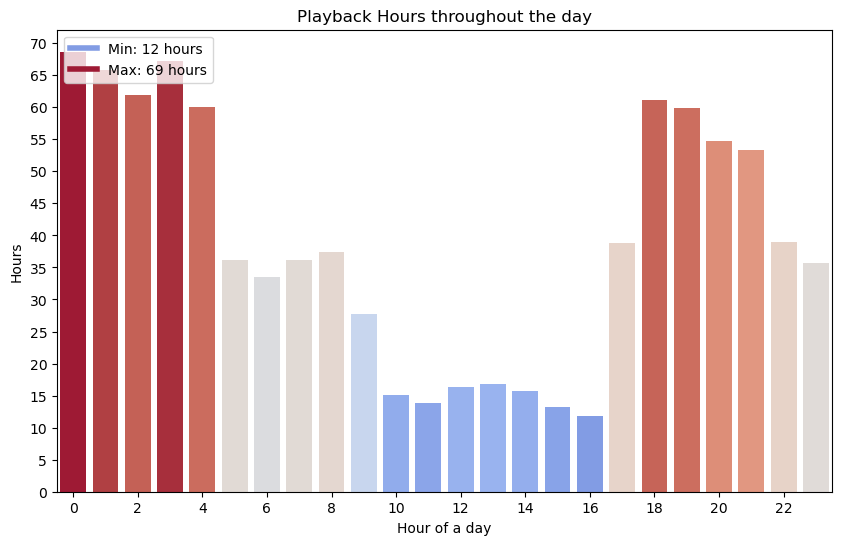

In [6]:
# Assuming 'time' is of type datetime.time
df['time_hour'] = df['time'].apply(lambda x: x.hour)

# Group by date, hour, and weekday, and calculate hours listened
day_hour = df.groupby(['time_hour']).agg(hoursListened=('minutes', 'sum')).reset_index()
day_hour['hoursListened'] /= 60  # Convert minutes to hours

# Create a custom color palette where higher hours are redder and lower hours are bluer
max_hours = day_hour['hoursListened'].max()
custom_palette = sns.color_palette("coolwarm", as_cmap=True)
colors = custom_palette(day_hour['hoursListened'] / max_hours)

# Plotting using seaborn with the custom color palette
plt.figure(figsize=(10, 6))
bars = sns.barplot(data=day_hour, x='time_hour', y='hoursListened', palette=colors)
plt.title('Playback Hours throughout the day')
plt.xlabel('Hour of a day')
plt.ylabel('Hours')
plt.xticks(range(0, 24, 2))
plt.yticks(range(0, 75, 5))

# Find the indices of the minimum and maximum values
min_index = day_hour['hoursListened'].idxmin()
max_index = day_hour['hoursListened'].idxmax()

# Get the colors of the minimum and maximum bars
min_color = bars.patches[min_index].get_facecolor()
max_color = bars.patches[max_index].get_facecolor()

# Create custom legend
legend_labels = [f"Min: {day_hour['hoursListened'].min():.0f} hours", f"Max: {day_hour['hoursListened'].max():.0f} hours"]
legend_handles = [plt.Line2D([0], [0], color=min_color, linewidth=4),
                  plt.Line2D([0], [0], color=max_color, linewidth=4)]

plt.legend(legend_handles, legend_labels, loc='upper left')

plt.show()

# Conclusion: since I am a night owl, I listen in the wee mornings until it's bedtime


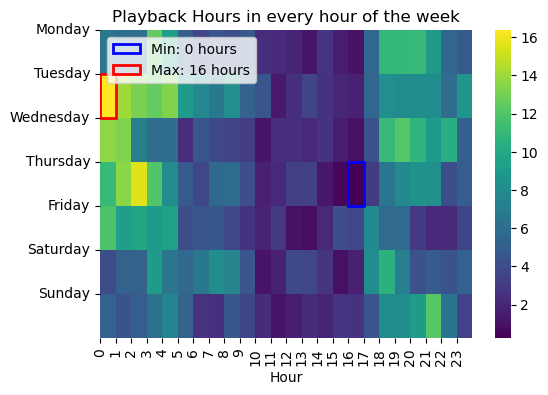

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Assuming 'time' is of type datetime.time
df['time_hour'] = df['time'].apply(lambda x: x.hour)

# Group by day and time_hour, and calculate total hours listened
weekday_hour = df.groupby(['day', 'time_hour']).agg(hours=('minutes', 'sum')).reset_index()
weekday_hour['hours'] /= 60  # Convert minutes to hours

# Sort weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_hour['day'] = pd.Categorical(weekday_hour['day'], categories=weekday_order, ordered=True)
weekday_hour['day_number'] = weekday_hour['day'].cat.codes  # Convert day names to integers

# Plotting using seaborn with a custom color map
plt.figure(figsize=(6, 4))
sns.heatmap(data=weekday_hour.pivot('day_number', 'time_hour', 'hours'), cmap='viridis', annot=False, vmax=weekday_hour['hours'].max())

# Customize the plot
plt.title('Playback Hours in every hour of the week')
plt.xlabel('Hour')
plt.ylabel('')
plt.xticks(range(24), labels=[str(i) for i in range(24)])  # Label hours from 0 to 23
plt.yticks(ticks=range(len(weekday_order)), labels=weekday_order, rotation=0)  # Sort and label weekdays

# Find the indices of the minimum and maximum values
min_index = weekday_hour['hours'].idxmin()
max_index = weekday_hour['hours'].idxmax()

## Draw rectangles around the minimum and maximum values
min_rect = Rectangle((weekday_hour.loc[min_index, 'time_hour'], weekday_hour.loc[min_index, 'day_number']), 1, 1, fill=False, edgecolor='blue', linewidth=2)
max_rect = Rectangle((weekday_hour.loc[max_index, 'time_hour'], weekday_hour.loc[max_index, 'day_number']), 1, 1, fill=False, edgecolor='red', linewidth=2)

# Add rectangles to the plot
plt.gca().add_patch(min_rect)
plt.gca().add_patch(max_rect)

# Customize the legend
legend_labels = [f"Min: {weekday_hour['hours'].min():.0f} hours", f"Max: {weekday_hour['hours'].max():.0f} hours"]
legend_handles = [min_rect, max_rect]

plt.legend(legend_handles, legend_labels, loc='upper left')



# Conclusion: I am most active on Tuesday midnight to 8 am, assuming because I do not have classes on Tuesdays


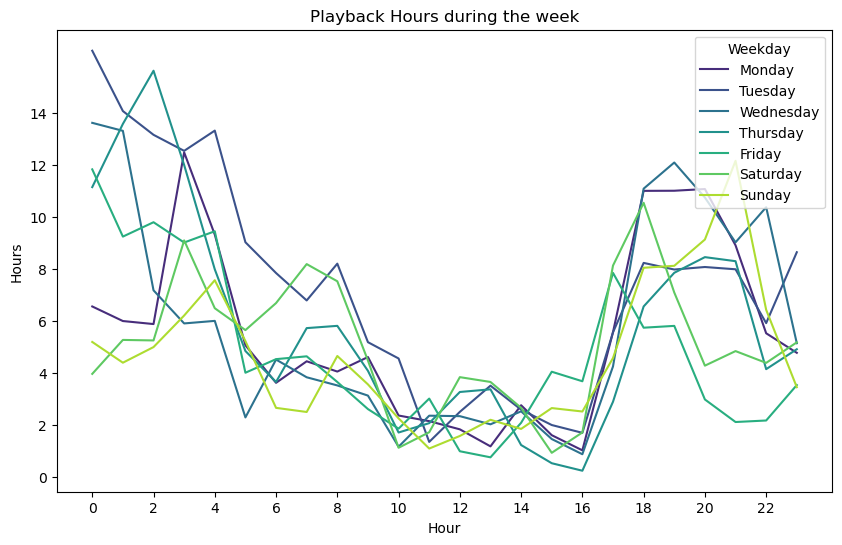

In [8]:
# Assuming 'df' is your DataFrame in Python
# Replace this with your actual DataFrame

# Group by weekday and hour, and calculate total hours listened
week_hour = df.groupby(['day', 'time_hour']).agg(hours=('minutes', 'sum')).reset_index()
week_hour['hours'] /= 60  # Convert minutes to hours

# Define the order of weekdays
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Plotting using seaborn with specified order
plt.figure(figsize=(10, 6))
sns.lineplot(data=week_hour, x='time_hour', y='hours', hue='day', palette='viridis', hue_order=weekday_order)

# Customize the plot
plt.title('Playback Hours during the week')
plt.xlabel('Hour')
plt.ylabel('Hours')  # Include the y-axis label
plt.xticks(range(0, 24, 2))
plt.yticks(range(0, 16, 2))
plt.legend(title='Weekday', loc='upper right')

plt.show()

# conclusion: to confirm, again, Tuesdays are the days I listen to music most.


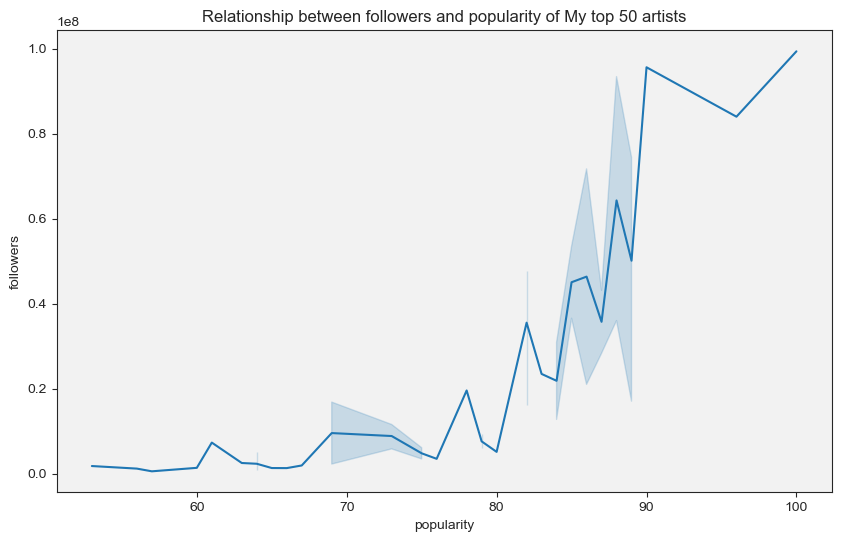

In [16]:
# Set up your Spotify API credentials
client_id = '6fb25a0d9045440f8fb7da51e36225b4'
client_secret = 'a2fc6384d7f74fdf9c62bde01af5a635'
redirect_uri = 'http://localhost:3000'

# Set up the Spotipy client
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='user-top-read'))

# Get the user's top artists
top_artists_real = sp.current_user_top_artists(time_range='long_term', limit=50)

# Extract relevant information from the API response
top_artists_data = {
    'name': [artist['name'] for artist in top_artists_real['items']],
    'genres': [artist['genres'] for artist in top_artists_real['items']],
    'popularity': [artist['popularity'] for artist in top_artists_real['items']],
    'spotify_url': [artist['external_urls']['spotify'] for artist in top_artists_real['items']],
    'artist_id': [artist['id'] for artist in top_artists_real['items']]
}

# Create a DataFrame
top_artists_real_df = pd.DataFrame(top_artists_data)

# Concatenate genres into a single string
top_artists_real_df['genres'] = top_artists_real_df['genres'].apply(lambda x: ', '.join(x) if x else '')

# Add a new column for followers
top_artists_real_df['followers'] = top_artists_real_df['artist_id'].apply(lambda x: sp.artist(x)['followers']['total'])

# Display the resulting DataFrame
top_artists_real_df

# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.set_style('ticks', {'axes.facecolor': '0.95', 'figure.facecolor': '0.95'})
sns.lineplot(data=top_artists_real_df, y='followers', x='popularity')
plt.title('Relationship between followers and popularity of My top 50 artists')
plt.show()


In [17]:
# Function to get genres from Spotify API
def get_genres_from_api(artist_id):
    try:
        artist_info = sp.artist(artist_id)
        genres = artist_info['genres']
        return ', '.join(genres)
    except Exception as e:
        print(f"Error getting genres for artist {artist_id}: {str(e)}")
        return None

# Function to get artist_id from Spotify API
def get_artist_id_from_api(artist_name):
    try:
        result = sp.search(q=f'artist:{artist_name}', type='artist')
        artist_id = result['artists']['items'][0]['id']
        return artist_id
    except Exception as e:
        return None

# Identify if the artist is K-pop, Western, or Other
def classify_genre(genres):
    if genres and ('k-pop' in genres.lower()):
        return 'K-pop'
    elif genres and ('pop' in genres.lower()):
        return 'Pop'
    else:
        return 'Other'

def get_genres_for_top_artists(artist_name):
    try:
        result = sp.search(q=f'artist:{artist_name}', type='artist')
        artist_id = result['artists']['items'][0]['id']
        artist_info = sp.artist(artist_id)
        genres = artist_info['genres']
        return ', '.join(genres)
    except Exception as e:
        print(f"Error getting genres for artist {artist_name}: {str(e)}")
        return None


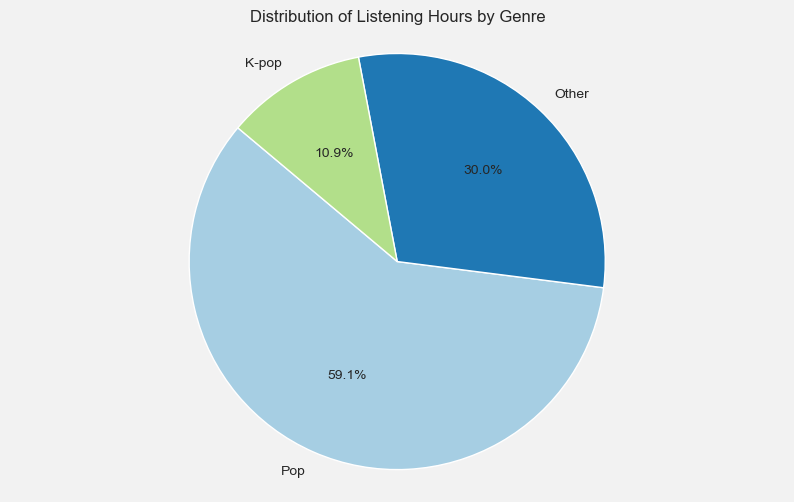

In [18]:
# Group by artistName and calculate total listened hours
artists_played = df.groupby('master_metadata_album_artist_name')['ms_played'].sum().reset_index()
artists_played['hours_played'] = artists_played['ms_played'] / (1000 * 60 * 60)  # Convert ms to hours

# Add a 'artist_id' column to your DataFrame
artists_played['artist_id'] = artists_played['master_metadata_album_artist_name'].apply(get_artist_id_from_api)

# Drop rows with missing artist IDs
artists_played = artists_played.dropna(subset=['artist_id'])

# Add a 'genres' column to your DataFrame
artists_played['genres'] = artists_played['artist_id'].apply(get_genres_from_api)

# Drop rows with missing artist IDs
artists_played = artists_played.dropna(subset=['artist_id'])

# Apply genre classification
artists_played['main_genre'] = artists_played['genres'].apply(classify_genre)

# Group by genres and sum the hours
top_genres = artists_played.groupby('main_genre')['hours_played'].sum().reset_index()

# Sort genres by hours played in descending order
top_genres = top_genres.sort_values(by='hours_played', ascending=False)

# Plotting using matplotlib
plt.figure(figsize=(10, 6))
plt.pie(top_genres['hours_played'], labels=top_genres['main_genre'], autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Distribution of Listening Hours by Genre')
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()



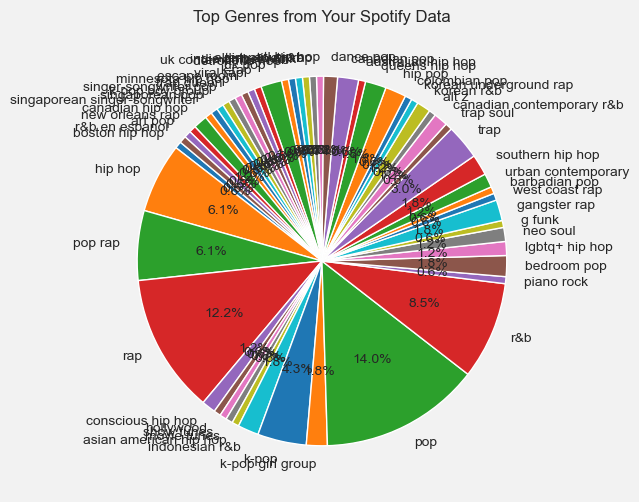

In [20]:
from collections import Counter

# Get the user's top tracks
top_tracks_response = sp.current_user_top_tracks(time_range='long_term', limit=50)

# Extract genres from artists
top_genres = [genre for track in top_tracks_response['items'] for artist in track['artists'] for genre in sp.artist(artist['id'])['genres']]

# Count the occurrences of each genre
genre_counts = Counter(top_genres)

# Plotting a pie chart
labels, values = zip(*genre_counts.items())
plt.figure(figsize=(10, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Top Genres from Your Spotify Data')
plt.show()


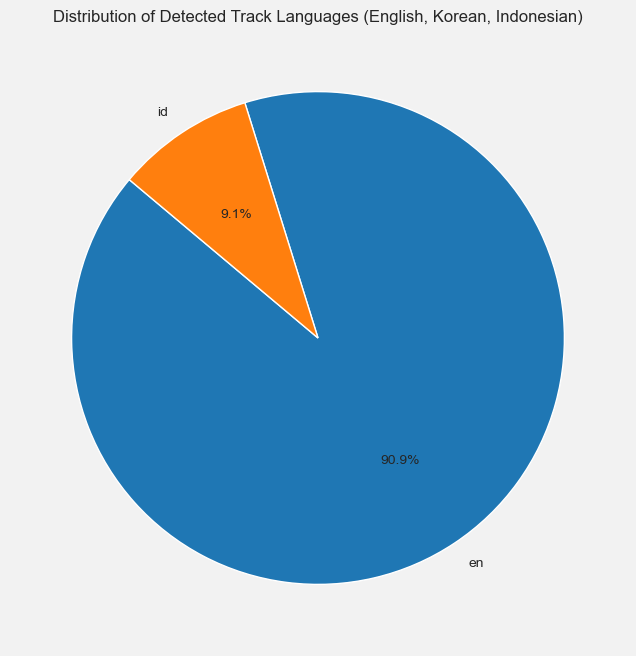

In [23]:
# Assuming 'top_tracks_response' is your API response containing top tracks
top_tracks_response = sp.current_user_top_tracks(time_range='long_term', limit=50)

# Extract languages from track names
track_languages = []

for track in top_tracks_response['items']:
    try:
        language = detect(track['name'])
        track_languages.append(language)
    except Exception as e:
        print(f"Error detecting language for track {track['name']}: {str(e)}")
        track_languages.append('Unknown')

# Filter languages to English, Korean, and Indonesian
target_languages = ['en', 'ko', 'id']  # English, Korean, Indonesian
filtered_languages = [lang for lang in track_languages if lang in target_languages]

# Count the occurrences of each language
language_counts = pd.Series(filtered_languages).value_counts()

# Plotting using a pie chart
plt.figure(figsize=(8, 8))
plt.pie(language_counts.values, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Detected Track Languages (English, Korean, Indonesian)')
plt.show()



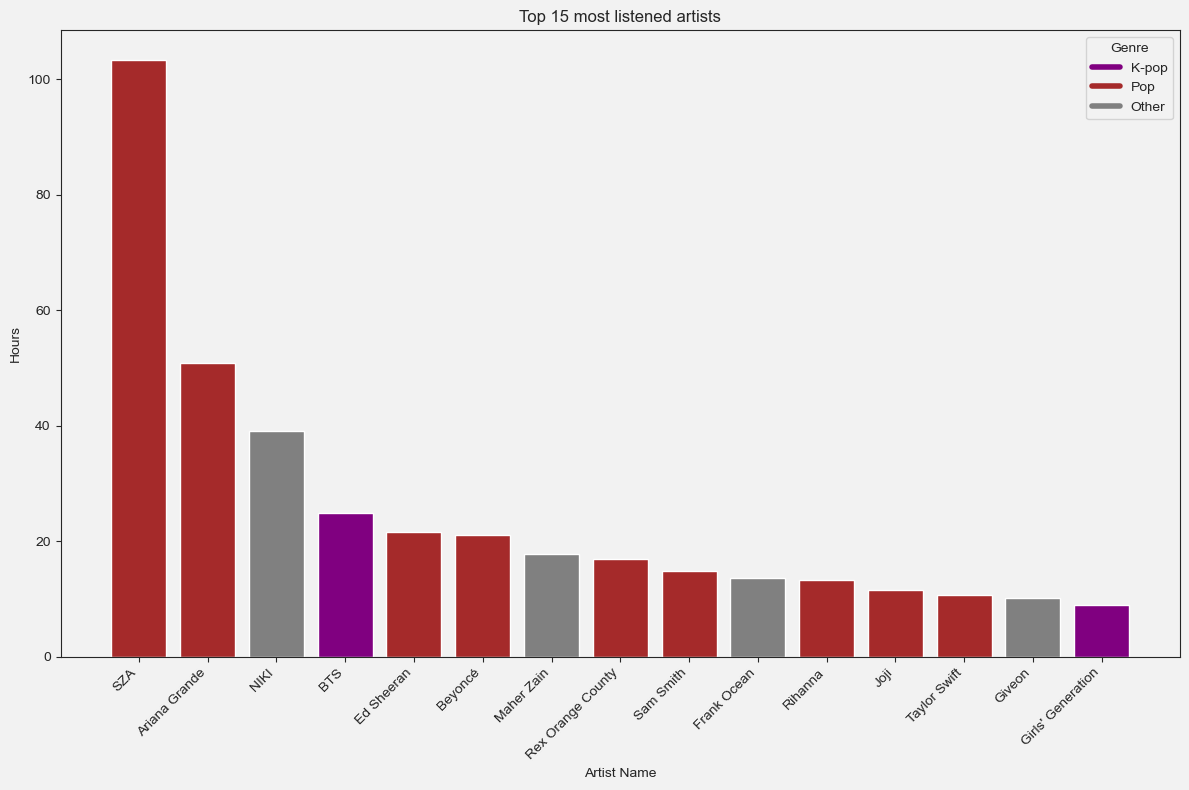

In [24]:
# Group by artistName and calculate total listened hours
top_artists = df.groupby('master_metadata_album_artist_name').agg(listenedHours=('minutes', 'sum')).reset_index()
top_artists['listenedHours'] /= 60  # Convert minutes to hours

# Sort by listened hours in descending order
top_artists = top_artists.sort_values(by='listenedHours', ascending=False)

# Select top 15
top_artists = top_artists.head(15)

    # Add a 'artist_id' column to your DataFrame
top_artists['artist_id'] = top_artists['master_metadata_album_artist_name'].apply(get_artist_id_from_api)

# # Drop rows with missing artist IDs
# top_artists = top_artists.dropna(subset=['artist_id'])

# Add a 'genres' column to your DataFrame by applying the function to the top 15 artists
top_artists['genres'] = top_artists['master_metadata_album_artist_name'].apply(get_genres_for_top_artists)

# Identify if the artist is K-pop, Western, or Other
top_artists['main_genre'] = top_artists['genres'].apply(classify_genre)

# Define colors for each genre
colors = {'K-pop': 'purple', 'Pop': 'brown', 'Other': 'gray'}

# Plotting using matplotlib with different colors for each genre
plt.figure(figsize=(12, 8))
bars = plt.bar(top_artists['master_metadata_album_artist_name'], top_artists['listenedHours'], color=top_artists['main_genre'].map(colors))
plt.title('Top 15 most listened artists')
plt.xlabel('Artist Name')
plt.ylabel('Hours')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  

# Add legend with colors
legend_labels = [plt.Line2D([0], [0], color=color, lw=4) for color in colors.values()]
plt.legend(legend_labels, colors.keys(), title='Genre', loc='upper right')

plt.show()


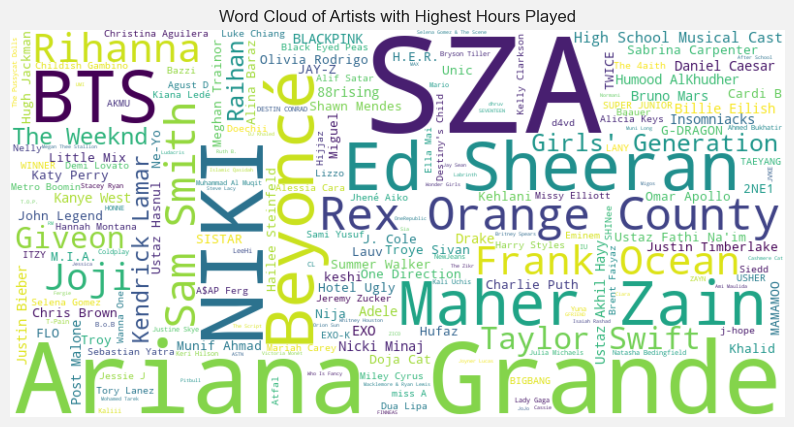

In [25]:
# Group by artistName and calculate total listened hours
artists_played = df.groupby('master_metadata_album_artist_name')['ms_played'].sum().reset_index()
artists_played['hours_played'] = artists_played['ms_played'] / (1000 * 60 * 60)  # Convert ms to hours

# Sort by hours played in descending order
artists_played = artists_played.sort_values(by='hours_played', ascending=False)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(zip(artists_played['master_metadata_album_artist_name'], artists_played['hours_played'])))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Artists with Highest Hours Played')
plt.show()

# different ways to plot

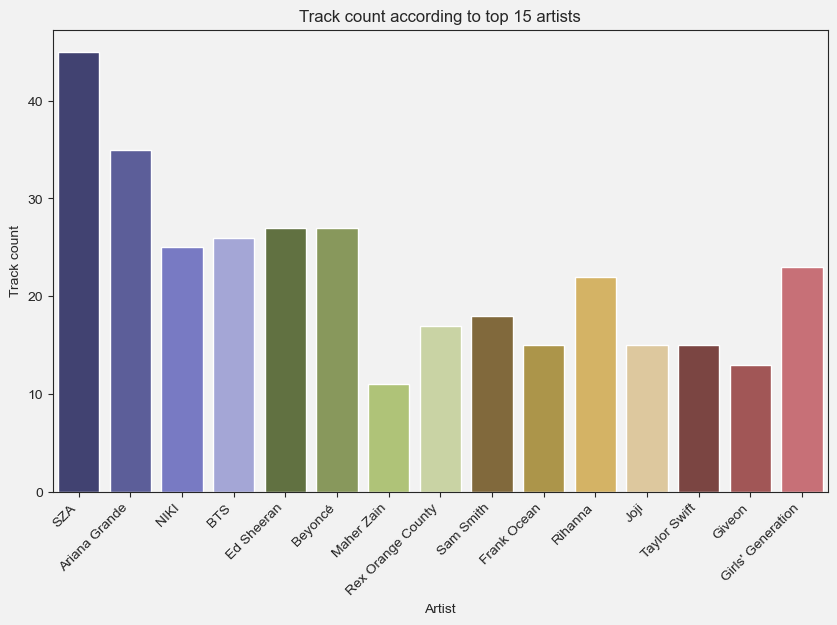

In [26]:
# Filter data for top_artists
top_artists_data = df[df['master_metadata_album_artist_name'].isin(top_artists["master_metadata_album_artist_name"])].copy()

# Group by artist name and track name, then count distinct tracks
top_artists_count = top_artists_data.groupby(['master_metadata_album_artist_name', 'master_metadata_track_name']).size().reset_index(name='count')

# Summarize track count per artist
top_artists_count = top_artists_count.groupby('master_metadata_album_artist_name')['count'].nunique().reset_index(name='trackCount')

# Plotting using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x='master_metadata_album_artist_name', y='trackCount', data=top_artists_count, palette="tab20b", order=top_artists["master_metadata_album_artist_name"])
plt.title('Track count according to top 15 artists')
plt.xlabel('Artist')
plt.ylabel('Track count')
plt.xticks(rotation=45, ha='right')
plt.show()

# it makes sense that i have high track count for my top 15 but im surprised that the top 7 (maher zain) only has 11 tracks

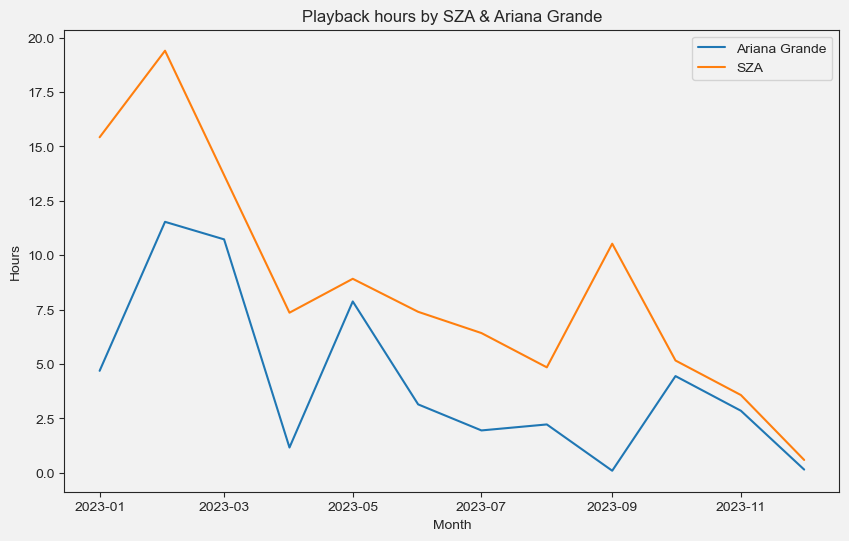

In [27]:
# Group by artistName and floor_date by month
sza_ariana = df.groupby(['master_metadata_album_artist_name', pd.Grouper(key='date', freq='MS')]).agg(hours=('minutes', 'sum')).reset_index()
sza_ariana['hours'] /= 60

# Filter artists
sza_ariana = sza_ariana[sza_ariana['master_metadata_album_artist_name'].isin(['SZA', 'Ariana Grande'])]

# Plotting using Matplotlib
plt.figure(figsize=(10, 6))
for artist, data in sza_ariana.groupby('master_metadata_album_artist_name'):
    plt.plot(data['date'], data['hours'], label=artist)

plt.title('Playback hours by SZA & Ariana Grande')
plt.xlabel('Month')
plt.ylabel('Hours')
plt.legend()
plt.show()

    # according to my spotify wrapped 2023, my top 2 artists are sza & ariana grande so i wantu see how do they compare against each.
    # i listen to them most in february hwoever, they both dropped in october,,,,, the following can see who do i listen most in october

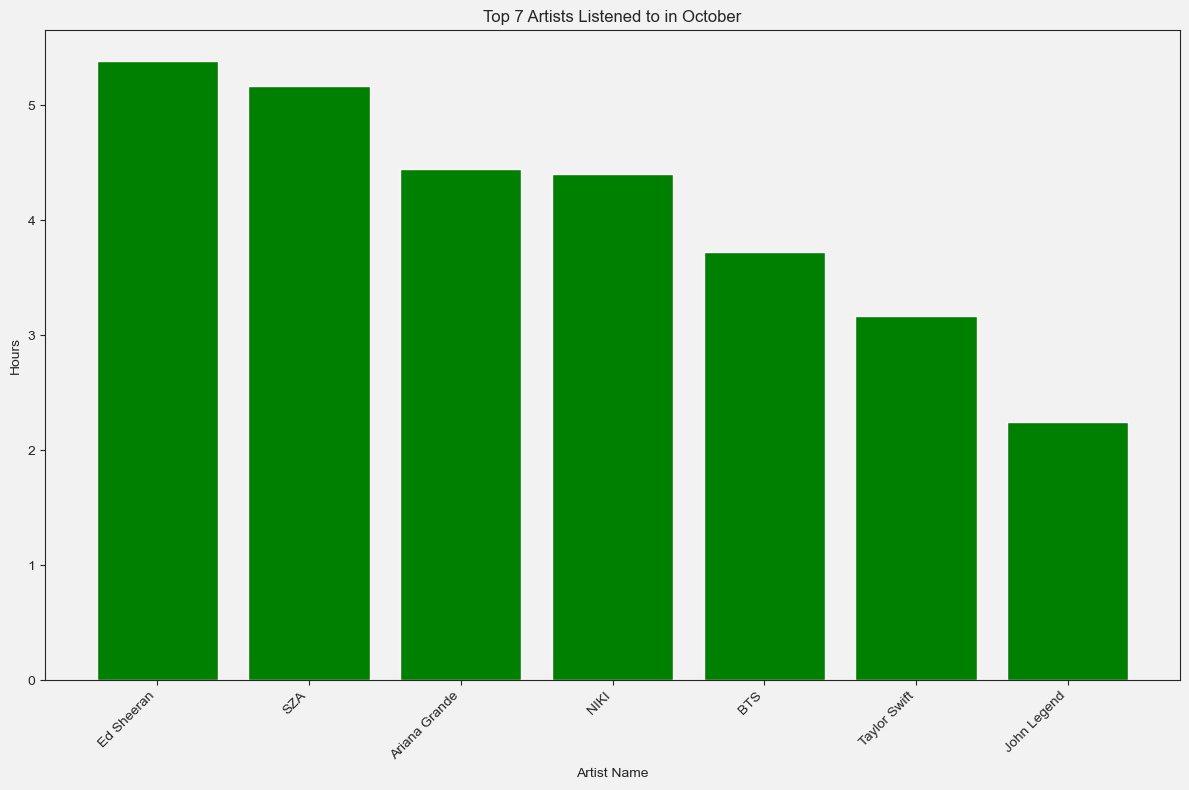

In [28]:
# Filter data for October
october_data = df[(df['date'].dt.month == 10)]

# Group by artistName and calculate total listened hours for October
october_artists = october_data.groupby('master_metadata_album_artist_name')['minutes'].sum().reset_index()
october_artists['hours'] = october_artists['minutes'] / 60  # Convert minutes to hours

# Sort by hours in descending order
october_artists = october_artists.sort_values(by='hours', ascending=False)

# Select top 7 artists
top_7_october_artists = october_artists.head(7)

# Plotting using matplotlib
plt.figure(figsize=(12, 8))
bars = plt.bar(top_7_october_artists['master_metadata_album_artist_name'], top_7_october_artists['hours'], color='green')
plt.title('Top 7 Artists Listened to in October')
plt.xlabel('Artist Name')
plt.ylabel('Hours')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

# understanbly so because Ed sheeran's latest album Autumn Variations came out in 29th Septermber 2023 and i must have spent the whole october binge listening


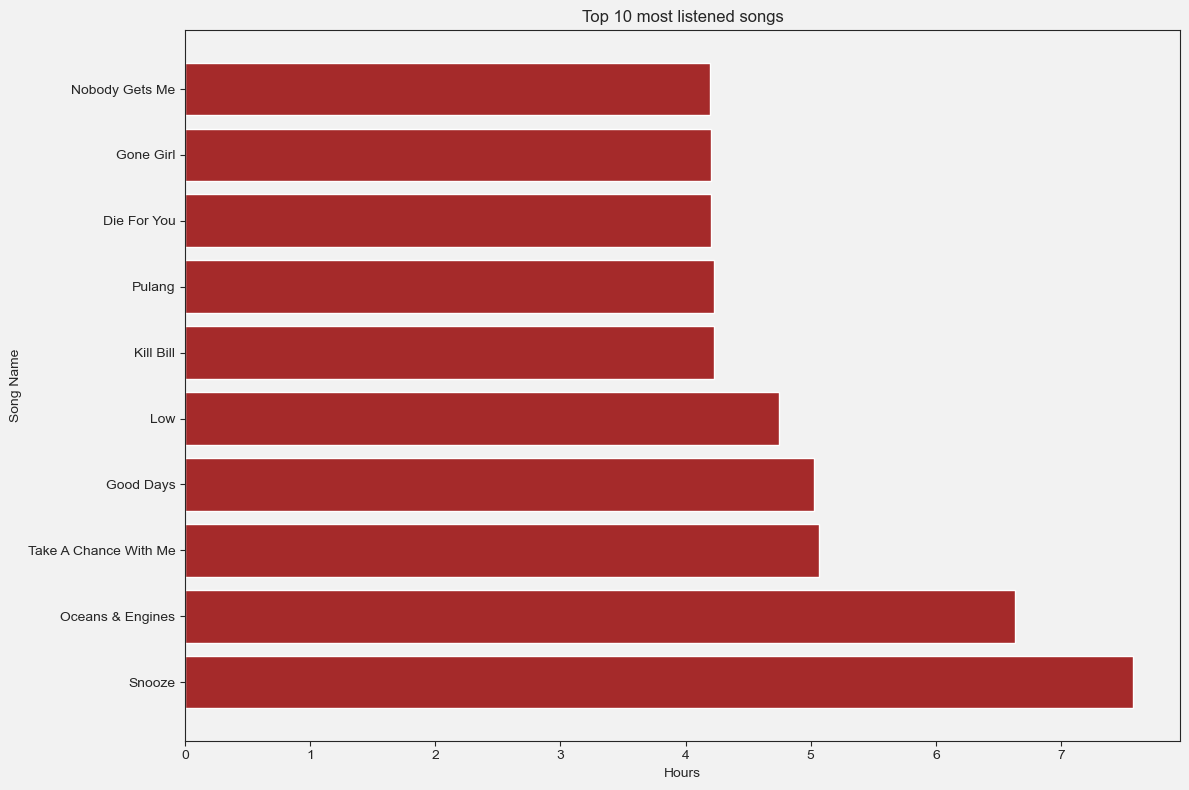

In [29]:
# Group by trackName and calculate total listened hours
top_songs = df.groupby('master_metadata_track_name').agg(listenedHours=('minutes', 'sum')).reset_index()
top_songs['listenedHours'] /= 60  # Convert minutes to hours

# Sort by listened hours in descending order and select top 10
top_songs = top_songs.sort_values(by='listenedHours', ascending=False).head(10)

# Define a color for the bars (you can use a valid matplotlib color)
bar_color = 'brown'  

# Plotting using matplotlib
plt.figure(figsize=(12, 8))
plt.barh(top_songs['master_metadata_track_name'], top_songs['listenedHours'], color=[bar_color] * len(top_songs))
plt.title('Top 10 most listened songs')
plt.xlabel('Hours')
plt.ylabel('Song Name')

plt.tight_layout()  
plt.show()

# add humour, thou these are my top 10 most listened songs, you would think i know the lyrics to snooze by sza by now but its crazy that I still do not know all the songs by heart. 

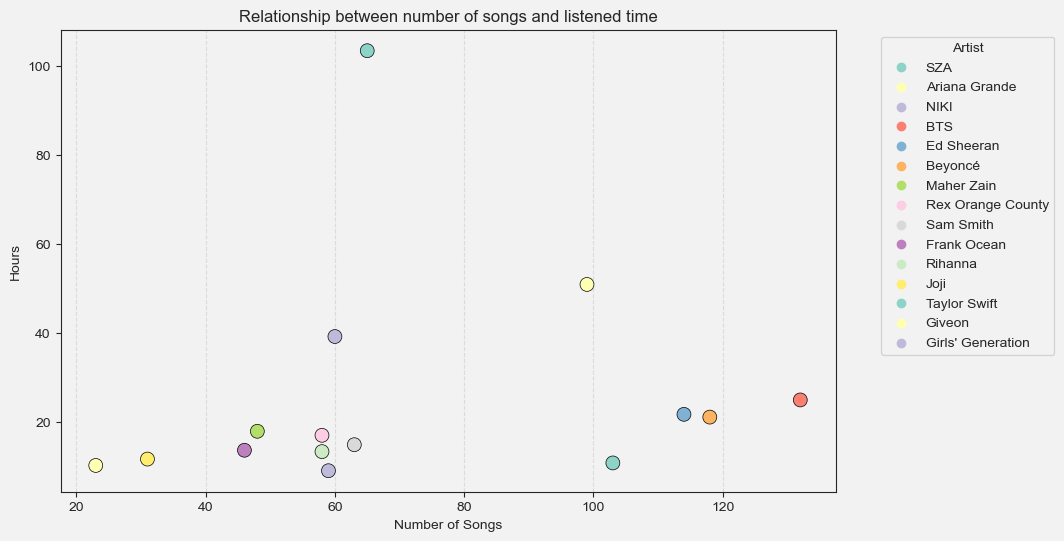

In [30]:
# Group by artistName and calculate listened hours and total songs
listenedTimes_songs = df.groupby('master_metadata_album_artist_name').agg(
    listenedHours=('minutes', 'sum'),
    total_songs=('master_metadata_track_name', 'nunique')
).reset_index()

# Convert listened hours to hours by dividing by 60
listenedTimes_songs['listenedHours'] /= 60

# Sort by listened hours and total songs in descending order
listenedTimes_songs = listenedTimes_songs.sort_values(by=['listenedHours', 'total_songs'], ascending=[False, False])

# Select top 15 rows
listenedTimes_songs = listenedTimes_songs.head(15)

# Create a color dictionary to map each artist to a specific color
color_dict = {artist: color for artist, color in zip(listenedTimes_songs['master_metadata_album_artist_name'], sns.color_palette('Set3', n_colors=len(listenedTimes_songs)))}

# Plotting using seaborn and matplotlib
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_songs', y='listenedHours', hue='master_metadata_album_artist_name', data=listenedTimes_songs, palette=color_dict, s=100, edgecolor='black', linewidth=0.5)
plt.title('Relationship between number of songs and listened time')
plt.xlabel('Number of Songs')
plt.ylabel('Hours')
plt.legend(title='Artist', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# number of songs has nothing to do with the listened time though, can take note that even though bts has most number of songs, i do not listen to it too much

In [31]:
# Calculate the duration between consecutive plays
df['time_diff'] = df['ts'].diff()

# Define binge listening as sessions longer than 1 hour
binge_sessions = df[df['time_diff'] > pd.Timedelta(hours=1)]

# Calculate the total time spent binge listening and the total time overall
total_binge_time = binge_sessions['time_diff'].sum()
total_time = df['time_diff'].sum()

# Calculate the percentage of time spent binge listening
percentage_binge = (total_binge_time / total_time) * 100

print(f'Percentage of time spent binge listening: {percentage_binge:.2f}%')

# i do not listen to music for short period, only binge listen

Percentage of time spent binge listening: 83.91%


<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

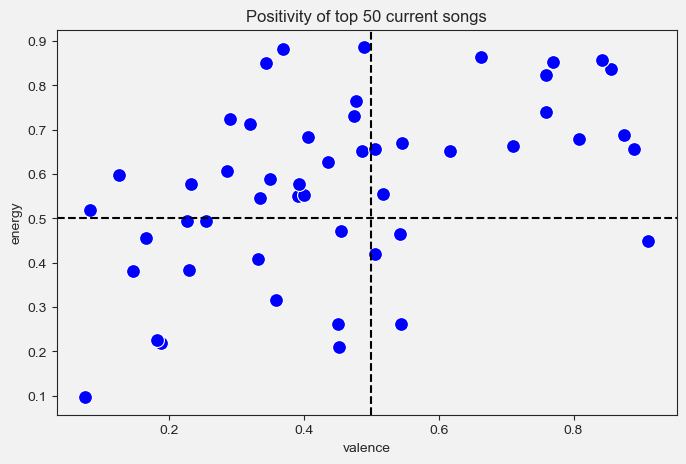

In [32]:
# Set up the Spotipy client with the correct scope
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='user-library-read user-top-read'))

# Get the user's top tracks
top_tracks = sp.current_user_top_tracks(limit=50, time_range='long_term')

# Extract track URIs from the top tracks
track_uris = [track['uri'] for track in top_tracks['items']]

# Get audio features for the top tracks
audio_features_list = sp.audio_features(track_uris)

# Extract relevant information
audio_features_df = pd.DataFrame(audio_features_list)

# Plotting using seaborn and matplotlib
plt.figure(figsize=(8, 5))
sns.scatterplot(x='valence', y='energy', data=audio_features_df, color='blue', s=100)
plt.axvline(x=0.5, color='black', linestyle='--')
plt.axhline(y=0.5, color='black', linestyle='--')
plt.title('Positivity of top 50 current songs')
plt.xlabel

# high energy = fast tempo, loud volume, and upbeat
# high valence sound more positive (happy, cheerful, euphoric)
# low valence sound more negative (sad, depressed, angry)
# have same amount of high/ low valence but theyre all high energy

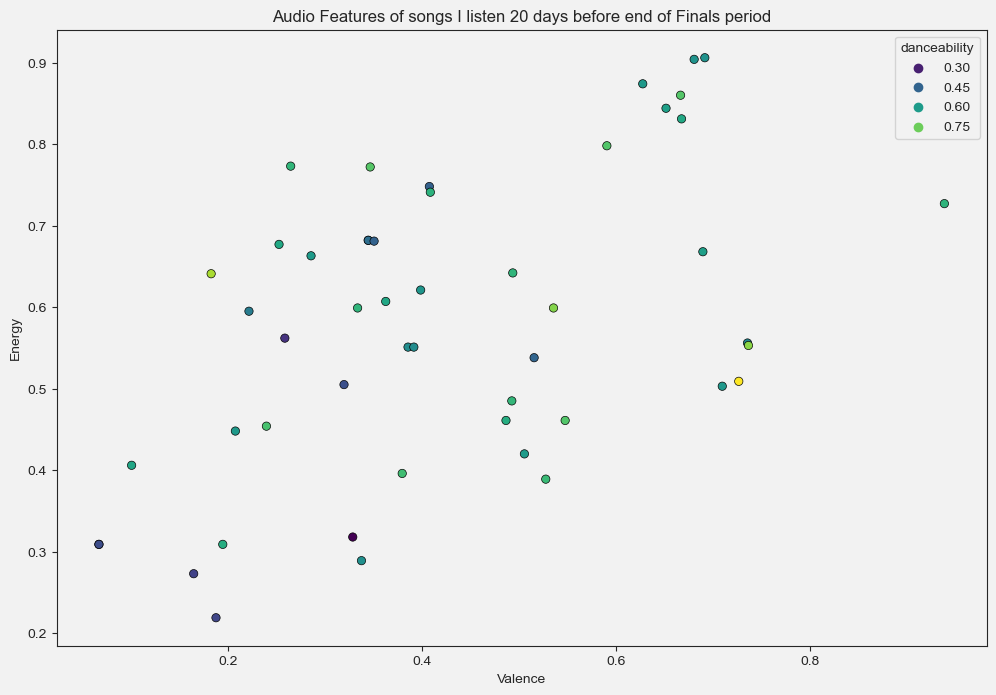

In [38]:
# Import datetime from the datetime module
from datetime import datetime, timedelta

# Set up the Spotipy client
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='user-read-recently-played'))

# Calculate the start and end date for the first week of November 2023
end_date = datetime(2023, 4, 20)

# Subtract 7 days to get the start date
start_date = end_date - timedelta(days=20)

# Convert dates to string format expected by the Spotify API
start_date_str = start_date.strftime('%Y-%m-%dT%H:%M:%S')  # Add time to make it midnight
end_date_str = end_date.strftime('%Y-%m-%dT%H:%M:%S')

# Retrieve recently played tracks
recently_played = sp.current_user_recently_played(after=start_date_str, limit=50)

# Extract relevant information from the API response
tracks_data = {
    'name': [],
    'artist': [],
    'played_at': [],
    'acousticness': [],
    'danceability': [],
    'energy': [],
    'instrumentalness': [],
    'liveness': [],
    'loudness': [],
    'tempo': [],
    'valence': []
}

for track in recently_played['items']:
    tracks_data['name'].append(track['track']['name'])
    tracks_data['artist'].append(', '.join([artist['name'] for artist in track['track']['artists']]))
    tracks_data['played_at'].append(track['played_at'])

    # Get additional audio features
    audio_features = sp.audio_features(track['track']['id'])[0]
    tracks_data['acousticness'].append(audio_features['acousticness'])
    tracks_data['danceability'].append(audio_features['danceability'])
    tracks_data['energy'].append(audio_features['energy'])
    tracks_data['instrumentalness'].append(audio_features['instrumentalness'])
    tracks_data['liveness'].append(audio_features['liveness'])
    tracks_data['loudness'].append(audio_features['loudness'])
    tracks_data['tempo'].append(audio_features['tempo'])
    tracks_data['valence'].append(audio_features['valence'])

# Create a DataFrame
tracks_df = pd.DataFrame(tracks_data)


# Plotting using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.scatterplot(x='valence', y='energy', data=tracks_df, hue='danceability', sizes=(20, 200), palette='viridis', edgecolor='black')
plt.title('Audio Features of songs I listen 20 days before end of Finals period')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.show()

# similiar to 'Positivity of top 50 current songs, i listen to both negative and positive songs with higher energy.

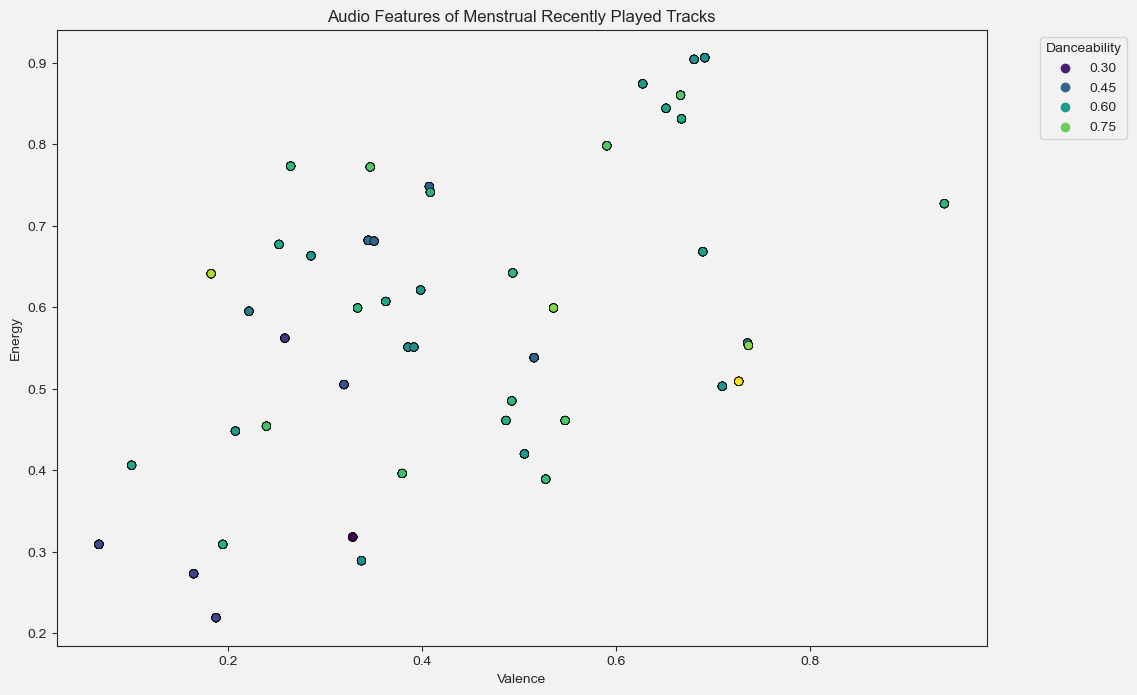

In [40]:
# Set up the Spotipy client
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri, scope='user-read-recently-played user-top-read'))

# Define the start and end dates for each menstrual cycle month in 2023
menstrual_cycles = [
    {'start': datetime(2023, 1, 16), 'end': datetime(2023, 1, 20)},
    {'start': datetime(2023, 2, 14), 'end': datetime(2023, 2, 20)},
    {'start': datetime(2023, 3, 19), 'end': datetime(2023, 3, 23)},
    {'start': datetime(2023, 4, 15), 'end': datetime(2023, 4, 19)},
    {'start': datetime(2023, 5, 21), 'end': datetime(2023, 5, 27)},
    {'start': datetime(2023, 6, 18), 'end': datetime(2023, 6, 22)},
    {'start': datetime(2023, 7, 22), 'end': datetime(2023, 7, 26)},
    {'start': datetime(2023, 8, 23), 'end': datetime(2023, 8, 29)},
    {'start': datetime(2023, 9, 27), 'end': datetime(2023, 10, 1)},
    {'start': datetime(2023, 11, 12), 'end': datetime(2023, 11, 16)},
    {'start': datetime(2023, 12, 12), 'end': datetime(2023, 12, 16)}
]

# Fetch recently played tracks for each menstrual cycle month
tracks_data = {
    'name': [],
    'artist': [],
    'played_at': [],
    'acousticness': [],
    'danceability': [],
    'energy': [],
    'instrumentalness': [],
    'liveness': [],
    'loudness': [],
    'tempo': [],
    'valence': [],
}

for cycle in menstrual_cycles:
    # Fetch recently played tracks for the start date
    recently_played_start = sp.current_user_recently_played(after=cycle['start'].strftime('%Y-%m-%dT%H:%M:%S'), limit=50)
    
    # Fetch recently played tracks for the end date
    recently_played_end = sp.current_user_recently_played(before=cycle['end'].strftime('%Y-%m-%dT%H:%M:%S'), limit=50)

    # Combine the results
    recently_played = recently_played_start['items'] + recently_played_end['items']

    for track in recently_played:
        tracks_data['name'].append(track['track']['name'])
        tracks_data['artist'].append(', '.join([artist['name'] for artist in track['track']['artists']]))
        tracks_data['played_at'].append(track['played_at'])

        # Fetch audio features for each track
        audio_features = sp.audio_features(track['track']['uri'])[0]
        tracks_data['acousticness'].append(audio_features['acousticness'])
        tracks_data['danceability'].append(audio_features['danceability'])
        tracks_data['energy'].append(audio_features['energy'])
        tracks_data['instrumentalness'].append(audio_features['instrumentalness'])
        tracks_data['liveness'].append(audio_features['liveness'])
        tracks_data['loudness'].append(audio_features['loudness'])
        tracks_data['tempo'].append(audio_features['tempo'])
        tracks_data['valence'].append(audio_features['valence'])

# Create a DataFrame
tracks_df = pd.DataFrame(tracks_data)

# Plotting using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.scatterplot(x='valence', y='energy', data=tracks_df, hue='danceability', sizes=(20, 200), palette='viridis', edgecolor='black', linewidth=0.5)
plt.title('Audio Features of Menstrual Recently Played Tracks')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.legend(title='Danceability', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# similar pattern

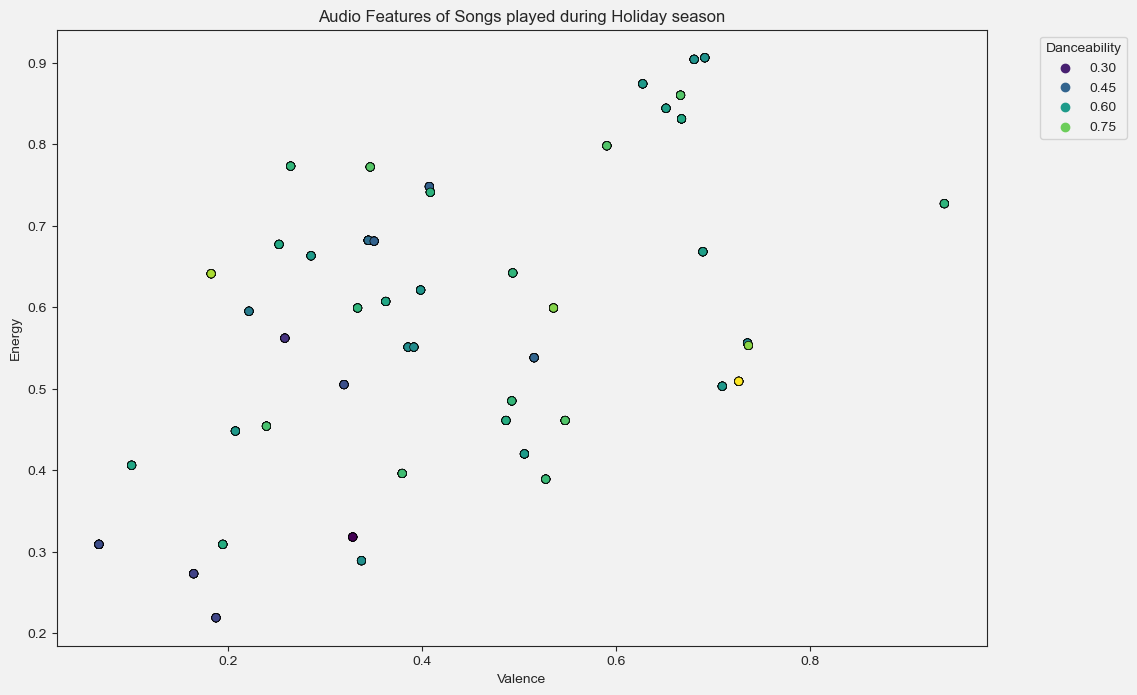

In [42]:
# Define the start and end dates for each holiday in 2023
holidays = [
    {'start': datetime(2023, 1, 1), 'end': datetime(2023, 1, 2), 'name': 'New Year'}, 
    {'start': datetime(2023, 1, 22), 'end': datetime(2023, 1, 23), 'name': 'Chinese New Year'},
    {'start': datetime(2023, 4, 7), 'end': datetime(2023, 4, 8), 'name': 'Good Friday'},
    {'start': datetime(2023, 4, 22), 'end': datetime(2023, 4, 23), 'name': 'Hari Raya Puasa'},
    {'start': datetime(2023, 5, 1), 'end': datetime(2023, 5, 2), 'name': 'Labour Day'},
    {'start': datetime(2023, 6, 3), 'end': datetime(2023, 6, 4), 'name': 'Vesak Day'},
    {'start': datetime(2023, 6, 29), 'end': datetime(2023, 6, 30), 'name': 'Hari Raya Haji'},
    {'start': datetime(2023, 8, 9), 'end': datetime(2023, 8, 10), 'name': 'National Day'},
    {'start': datetime(2023, 11, 12), 'end': datetime(2023, 11, 13), 'name': 'Deepavali'},
    {'start': datetime(2023, 12, 25), 'end': datetime(2023, 12, 26), 'name': 'Christmas Day'},
]

# Fetch recently played tracks for each holiday
tracks_data = {
    'name': [],
    'artist': [],
    'played_at': [],
    'acousticness': [],
    'danceability': [],
    'energy': [],
    'instrumentalness': [],
    'liveness': [],
    'loudness': [],
    'tempo': [],
    'valence': [],
}

for holiday in holidays:
    # Fetch recently played tracks for the holiday
    recently_played_holiday = sp.current_user_recently_played(
        after=holiday['start'].strftime('%Y-%m-%dT%H:%M:%S'),
        limit=50
    )

    for track in recently_played_holiday['items']:
        tracks_data['name'].append(track['track']['name'])
        tracks_data['artist'].append(', '.join([artist['name'] for artist in track['track']['artists']]))
        tracks_data['played_at'].append(track['played_at'])

        # Fetch audio features for each track
        audio_features = sp.audio_features(track['track']['uri'])[0]
        tracks_data['acousticness'].append(audio_features['acousticness'])
        tracks_data['danceability'].append(audio_features['danceability'])
        tracks_data['energy'].append(audio_features['energy'])
        tracks_data['instrumentalness'].append(audio_features['instrumentalness'])
        tracks_data['liveness'].append(audio_features['liveness'])
        tracks_data['loudness'].append(audio_features['loudness'])
        tracks_data['tempo'].append(audio_features['tempo'])
        tracks_data['valence'].append(audio_features['valence'])

# Create a DataFrame
tracks_df = pd.DataFrame(tracks_data)

# Plotting using seaborn and matplotlib
plt.figure(figsize=(12, 8))
sns.scatterplot(x='valence', y='energy', data=tracks_df, hue='danceability', sizes=(20, 200), palette='viridis', edgecolor='black', linewidth=0.5)
plt.title('Audio Features of Songs played during Holiday season')
plt.xlabel('Valence')
plt.ylabel('Energy')
plt.legend(title='Danceability', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()